In [1]:
# ======================================================
# 🧠 BiGRU + Multi-Head Attention + HMM (3 inputs version)
#     Inputs: Image + OpenFace.csv + MergeFeature.csv
# ======================================================

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [3]:
# ==========================
# ĐỊNH NGHĨA ĐƯỜNG DẪN DATA
# ==========================

# Path đến ảnh crop (CELEB)
base_path = r'C:\Users\3\Desktop\Dataset\faceplus_processed_research_final_2_crop'
categories = ['fake', 'real']

# Path đến CSV fusion: FFT + DCT + SRM + OpenFace (fake / real)
# LƯU Ý: thêm .csv ở cuối (sửa lại cho đúng với máy bạn nếu cần)
csv_fake_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_fake_FFDataset.csv'
csv_real_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_real_FFDataset.csv'



In [4]:
# ==========================
# TẠO DATAFRAME ẢNH
# ==========================

data = []

for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.isdir(category_path):
        continue

    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                # Ví dụ: 000_id0_0000_frame_0000.jpg
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]   # "000"
                frame = frame_part.split('.')[0]  # "0000"
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

df = pd.DataFrame(data)

# Gán nhãn số
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})

# Tạo video_key (id + label) để gom theo video
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']



In [5]:
df

,filename,path,id,frame,label,label_id,video_key
0,000_003_frame_0000.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,0,fake,0,0_fake
1,000_003_frame_0001.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,1,fake,0,0_fake
2,000_003_frame_0002.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,2,fake,0,0_fake
3,000_003_frame_0003.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,3,fake,0,0_fake
4,000_003_frame_0004.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,4,fake,0,0_fake
...,...,...,...,...,...,...,...
59803,999_frame_0025.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,25,real,1,999_real
59804,999_frame_0026.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,26,real,1,999_real
59805,999_frame_0027.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,27,real,1,999_real
59806,999_frame_0028.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,28,real,1,999_real


In [6]:
# ================================================
# ĐỌC CSV FUSION: FFT + DCT + SRM + OPENFACE
# THAY THẾ CHO CSV OPENFACE CŨ
# ================================================

from sklearn.preprocessing import StandardScaler

print("📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...")

# Đọc trực tiếp 2 file CSV fake / real
if not os.path.exists(csv_fake_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_fake_path}")
if not os.path.exists(csv_real_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_real_path}")

df_fake_features = pd.read_csv(csv_fake_path)
df_real_features = pd.read_csv(csv_real_path)

# Gộp chung
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)

# Các cột không phải feature
non_feature_cols = [
    'filename',
    'width', 'height', 'color_mode', 'resize_to', 'do_hann'
]
non_feature_cols = [c for c in non_feature_cols if c in df_all_features.columns]

# Tất cả cột còn lại là feature: SRM + DCT + FFT + OpenFace (feature_1..feature_674)
feature_cols = [c for c in df_all_features.columns if c not in non_feature_cols]

print(f"✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): {len(feature_cols)}")

# Tạo dict: filename -> vector feature
csv_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    feats = row[feature_cols].values.astype('float32')
    csv_features[filename] = feats

csv_feature_dim = len(feature_cols)
print(f"✅ Loaded {len(csv_features)} fused feature vectors")
print(f"✅ Each fused vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")


📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...
✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): 952
✅ Loaded 59808 fused feature vectors
✅ Each fused vector has 952 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [7]:
# ==========================
# IMPORT THÊM CHO MODEL
# ==========================

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, GRU, Dropout, Dense, GlobalAveragePooling2D,
    Concatenate, BatchNormalization, Bidirectional, MultiHeadAttention,
    LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode


In [8]:
# ==========================
# CẤU HÌNH
# ==========================

video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# ======================================
# FIT STANDARD SCALER TRÊN FUSED FEATURES
# ======================================

print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in csv_features:
            all_csv_features.append(csv_features[filename])

if len(all_csv_features) == 0:
    raise RuntimeError("Không thu được sample nào để fit StandardScaler. Kiểm tra lại mapping filename giữa ảnh và CSV.")

all_csv_features = np.array(all_csv_features)
csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# ==========================
# DATA GENERATOR
# ==========================

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        super().__init__()  # để Keras khỏi warning PyDataset
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []

            for path in frames:
                # Load & resize image
                img = cv2.imread(path)
                if img is None:
                    img = np.zeros((*self.img_size, 3), dtype='float32')
                else:
                    img = cv2.resize(img, self.img_size)
                    img = self.datagen.random_transform(img) if self.augment else img
                    img = img.astype('float32') / 255.0
                imgs.append(img)

                # Lấy fused CSV feature tương ứng filename
                filename = os.path.basename(path)
                if filename in csv_features:
                    csv_feat = csv_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)

            # Pad nếu số frame < sequence_len
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))

            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        # 💥 CHỖ QUAN TRỌNG: DÙNG TUPLE THAY CHO LIST
        X_img = np.array(batch_X_img)
        X_csv = np.array(batch_X_csv)
        y = np.array(batch_y)

        # Có 2 cách, chọn 1 trong 2 (mình recommend dùng dict cho rõ):

        # Cách 1: dùng dict, khớp đúng tên input của model
        return (
            {
                'image_input': X_img,
                'csv_input': X_csv
            },
            y
        )

        # Nếu thích dùng tuple thuần:
        # return (X_img, X_csv), y


🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 19982 samples


In [9]:
# ==========================
# MODEL BiGRU + MHA (NO KAN)
# ==========================

def build_model(sequence_len, img_size, csv_dim):
    # MobileNetV2 branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False

    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)

    # CSV features input (fused: SRM + DCT + FFT + OpenFace)
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')

    # BatchNormalization trước khi fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)

    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])

    # BiGRU layers
    x = Bidirectional(GRU(128, return_sequences=True, name='bigru_1'))(x_combined)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Bidirectional(GRU(64, return_sequences=True, name='bigru_2'))(x)
    x = Dropout(0.3, name='dropout_2')(x)

    # Multi-Head Self-Attention
    x_norm = LayerNormalization(name='ln_before_attention')(x)
    attn_output = MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        name='multi_head_attention'
    )(x_norm, x_norm)

    # Residual + LayerNorm
    x = tf.keras.layers.Add(name='residual_connection')([x, attn_output])
    x = LayerNormalization(name='ln_after_attention')(x)

    # Global average pooling over time
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.2, name='dropout_attention')(x)

    # Classification head
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)

    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='BiGRU_MultiHeadAttn')
    return model

# ==========================
# HMM POST-PROCESSING
# ==========================

def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ==========================
# TRAINING K-FOLD
# ==========================

print("\n🚀 Starting BiGRU + Multi-Head Self-Attention Training (NO KAN):")
print("   ✅ Bidirectional GRU (128 + 64 units)")
print("   ✅ Multi-Head Self-Attention (4 heads, 32 key_dim)")
print("   ✅ Residual connections + Layer Normalization")
print("   ✅ Normalized fused CSV features (SRM + DCT + FFT + OpenFace)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - BiGRU_MultiHeadAttn")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])

    print(f"\n📈 Model Architecture:")
    print(f"   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - BiGRU: 128 + 64 units (bidirectional)")
    print(f"   - Multi-Head Attention: 4 heads, 32 key_dim")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_bigru_mhattn.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

    print(f"\n✅ Fold {fold} Results (BiGRU_MultiHeadAttn):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - BiGRU_MultiHeadAttn Model (NO KAN)")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))


🚀 Starting BiGRU + Multi-Head Self-Attention Training (NO KAN):
   ✅ Bidirectional GRU (128 + 64 units)
   ✅ Multi-Head Self-Attention (4 heads, 32 key_dim)
   ✅ Residual connections + Layer Normalization
   ✅ Normalized fused CSV features (SRM + DCT + FFT + OpenFace)
   ✅ MobileNet (last 20 layers trainable)
   ✅ HMM post-processing


📊 Fold 1/5 - BiGRU_MultiHeadAttn

📈 Model Architecture:
   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)
   - Total params: 4,281,505
   - Trainable params: 3,225,137
   - BiGRU: 128 + 64 units (bidirectional)
   - Multi-Head Attention: 4 heads, 32 key_dim
   - Learning rate: 3e-4
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6253 - loss: 0.6488
Epoch 1: val_accuracy improved from None to 0.74375, saving model to best_model_fold1_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.6806 - loss: 0.5912 - val_accuracy: 0.7437 - val_loss: 0.5032 - learning_rate: 3.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8285 - loss: 0.4152
Epoch 2: val_accuracy improved from 0.74375 to 0.80625, saving model to best_model_fold1_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - accuracy: 0.8326 - loss: 0.4024 - val_accuracy: 0.8062 - val_loss: 0.3883 - learning_rate: 3.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8720 - loss: 0.3061
Epoch 3: val_accuracy improved from 0.80625 to 0.85000, saving model to best_model_fold1_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step - accuracy: 0.8847 - loss: 0.2947 - val_accuracy: 0.8500 - val_loss: 0.3297 - learning_rate: 3.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9356 - loss: 0.2039
Epoch 4: val_accuracy improved from 0.85000 to 0.90625, saving model to best_model_fold1_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.9306 - loss: 0.2074 - val_accuracy: 0.9062 - val_loss: 0.2774 - learning_rate: 3.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9509 - loss: 0.1521
Epoch 5: val_accuracy did not improve from 0.90625
45/45 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.9521 - loss: 0.1464 - val_accuracy: 0.9062 - val_loss: 0.3232 - learning_rate: 3.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9697 - loss: 0.1052
Epoch 6: val_accuracy did not improve from 0.90625
45/45 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.9688 - loss: 0.1011 - val_accuracy: 0.9062 - val_loss: 0.3204 - learning_rate: 3.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9865 - loss: 0.0674
Epoch 7: val_accuracy did not improve from 0.90625

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.9847 - loss: 0.0649 - val_accuracy:

45/45 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.6743 - loss: 0.6020 - val_accuracy: 0.7812 - val_loss: 0.4422 - learning_rate: 3.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7974 - loss: 0.4380
Epoch 2: val_accuracy did not improve from 0.78125
45/45 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.8215 - loss: 0.4036 - val_accuracy: 0.7563 - val_loss: 0.4838 - learning_rate: 3.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8873 - loss: 0.2887
Epoch 3: val_accuracy improved from 0.78125 to 0.81250, saving model to best_model_fold2_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.8868 - loss: 0.2870 - val_accuracy: 0.8125 - val_loss: 0.4611 - learning_rate: 3.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9159 - loss: 0.2260
Epoch 4: val_accuracy improved from 0.81250 to 0.85625, saving model to best_model_fold2_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.9271 - loss: 0.2113 - val_accuracy: 0.8562 - val_loss: 0.3875 - learning_rate: 3.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9601 - loss: 0.1459
Epoch 5: val_accuracy improved from 0.85625 to 0.88750, saving model to best_model_fold2_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.9632 - loss: 0.1324 - val_accuracy: 0.8875 - val_loss: 0.3598 - learning_rate: 3.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9695 - loss: 0.0965
Epoch 6: val_accuracy improved from 0.88750 to 0.91250, saving model to best_model_fold2_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.9701 - loss: 0.0981 - val_accuracy: 0.9125 - val_loss: 0.3203 - learning_rate: 3.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9864 - loss: 0.0565
Epoch 7: val_accuracy did not improve from 0.91250
45/45 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.9826 - loss: 0.0640 - val_accuracy: 0.8938 - val_loss: 0.4316 - learning_rate: 3.0000e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9859 - loss: 0.0507
Epoch 8: val_accuracy did not improve from 0.91250
45/45 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.9861 - loss: 0.0476 - val_accuracy: 0.9125 - val_loss: 0.4362 - learning_rate: 3.0000e-04
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9902 - loss: 0.0343
Epoch 9: val_accuracy did not improve from 0.91250

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.9875 - loss: 0.0389 - val_accuracy:

45/45 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6965 - loss: 0.5818 - val_accuracy: 0.7375 - val_loss: 0.5119 - learning_rate: 3.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8398 - loss: 0.3750
Epoch 2: val_accuracy improved from 0.73750 to 0.77500, saving model to best_model_fold3_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step - accuracy: 0.8313 - loss: 0.3759 - val_accuracy: 0.7750 - val_loss: 0.4634 - learning_rate: 3.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8949 - loss: 0.2818
Epoch 3: val_accuracy improved from 0.77500 to 0.81250, saving model to best_model_fold3_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.8965 - loss: 0.2643 - val_accuracy: 0.8125 - val_loss: 0.4263 - learning_rate: 3.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9376 - loss: 0.1736
Epoch 4: val_accuracy improved from 0.81250 to 0.85000, saving model to best_model_fold3_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 252s 6s/step - accuracy: 0.9312 - loss: 0.1844 - val_accuracy: 0.8500 - val_loss: 0.4013 - learning_rate: 3.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9613 - loss: 0.1300
Epoch 5: val_accuracy did not improve from 0.85000
45/45 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9576 - loss: 0.1367 - val_accuracy: 0.8500 - val_loss: 0.3663 - learning_rate: 3.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9666 - loss: 0.0934
Epoch 6: val_accuracy did not improve from 0.85000
45/45 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9681 - loss: 0.0938 - val_accuracy: 0.7750 - val_loss: 0.8625 - learning_rate: 3.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9862 - loss: 0.0605
Epoch 7: val_accuracy improved from 0.85000 to 0.88750, saving model to best_model_fold3_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.9833 - loss: 0.0598 - val_accuracy: 0.8875 - val_loss: 0.3902 - learning_rate: 3.0000e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9823 - loss: 0.0621
Epoch 8: val_accuracy improved from 0.88750 to 0.89375, saving model to best_model_fold3_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - accuracy: 0.9854 - loss: 0.0526 - val_accuracy: 0.8938 - val_loss: 0.3450 - learning_rate: 3.0000e-04
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9970 - loss: 0.0271
Epoch 9: val_accuracy did not improve from 0.89375
45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.9951 - loss: 0.0284 - val_accuracy: 0.8750 - val_loss: 0.4561 - learning_rate: 3.0000e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9959 - loss: 0.0228
Epoch 10: val_accuracy did not improve from 0.89375
45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.9958 - loss: 0.0239 - val_accuracy: 0.8687 - val_loss: 0.5935 - learning_rate: 3.0000e-04
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9916 - loss: 0.0251
Epoch 11: val_accuracy did not improve from 0.89375

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.9931 - loss: 0.0231 - val_accu

45/45 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.6687 - loss: 0.6056 - val_accuracy: 0.7563 - val_loss: 0.5276 - learning_rate: 3.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8268 - loss: 0.4276
Epoch 2: val_accuracy did not improve from 0.75625
45/45 ━━━━━━━━━━━━━━━━━━━━ 298s 7s/step - accuracy: 0.8160 - loss: 0.4318 - val_accuracy: 0.7500 - val_loss: 0.5315 - learning_rate: 3.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8762 - loss: 0.3239
Epoch 3: val_accuracy improved from 0.75625 to 0.81250, saving model to best_model_fold4_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 294s 7s/step - accuracy: 0.8743 - loss: 0.3118 - val_accuracy: 0.8125 - val_loss: 0.3941 - learning_rate: 3.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9068 - loss: 0.2510
Epoch 4: val_accuracy improved from 0.81250 to 0.86250, saving model to best_model_fold4_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 299s 7s/step - accuracy: 0.9139 - loss: 0.2351 - val_accuracy: 0.8625 - val_loss: 0.3376 - learning_rate: 3.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9511 - loss: 0.1489
Epoch 5: val_accuracy improved from 0.86250 to 0.87500, saving model to best_model_fold4_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.9521 - loss: 0.1497 - val_accuracy: 0.8750 - val_loss: 0.3910 - learning_rate: 3.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9665 - loss: 0.1028
Epoch 6: val_accuracy improved from 0.87500 to 0.88125, saving model to best_model_fold4_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 301s 7s/step - accuracy: 0.9639 - loss: 0.1063 - val_accuracy: 0.8813 - val_loss: 0.3834 - learning_rate: 3.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9721 - loss: 0.0862
Epoch 7: val_accuracy did not improve from 0.88125

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.9806 - loss: 0.0700 - val_accuracy: 0.8813 - val_loss: 0.4712 - learning_rate: 3.0000e-04
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9856 - loss: 0.0512
Epoch 8: val_accuracy did not improve from 0.88125
45/45 ━━━━━━━━━━━━━━━━━━━━ 297s 7s/step - accuracy: 0.9903 - loss: 0.0451 - val_accuracy: 0.8813 - val_loss: 0.5036 - learning_rate: 1.5000e-04
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9941 - loss: 0.0384
Epoch 9: val_accuracy improved from 0.88125 to 0.89375, saving model to best_model_fold4_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 299s 7s/step - accuracy: 0.9951 - loss: 0.0342 - val_accuracy: 0.8938 - val_loss: 0.5001 - learning_rate: 1.5000e-04
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9954 - loss: 0.0267
Epoch 10: val_accuracy did not improve from 0.89375

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 ━━━━━━━━━━━━━━━━━━━━ 304s 7s/step - accuracy: 0.9958 - loss: 0.0245 - val_accuracy: 0.8875 - val_loss: 0.5629 - learning_rate: 1.5000e-04
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9935 - loss: 0.0228
Epoch 11: val_accuracy did not improve from 0.89375
45/45 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.9965 - loss: 0.0206 - val_accuracy: 0.8813 - val_loss: 0.5664 - learning_rate: 7.5000e-05
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0165
Epoch 12: val_accuracy did not improve from 0.89375
45/45 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 1.0000 - loss: 0.0164 - val_ac

45/45 ━━━━━━━━━━━━━━━━━━━━ 383s 8s/step - accuracy: 0.6840 - loss: 0.5844 - val_accuracy: 0.7563 - val_loss: 0.5016 - learning_rate: 3.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8407 - loss: 0.3858
Epoch 2: val_accuracy improved from 0.75625 to 0.76875, saving model to best_model_fold5_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - accuracy: 0.8472 - loss: 0.3720 - val_accuracy: 0.7688 - val_loss: 0.5134 - learning_rate: 3.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9121 - loss: 0.2463
Epoch 3: val_accuracy improved from 0.76875 to 0.80625, saving model to best_model_fold5_bigru_mhattn.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 342s 8s/step - accuracy: 0.9104 - loss: 0.2464 - val_accuracy: 0.8062 - val_loss: 0.5095 - learning_rate: 3.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9295 - loss: 0.1805
Epoch 4: val_accuracy did not improve from 0.80625

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 ━━━━━━━━━━━━━━━━━━━━ 333s 7s/step - accuracy: 0.9417 - loss: 0.1706 - val_accuracy: 0.7812 - val_loss: 0.5931 - learning_rate: 3.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9696 - loss: 0.1172
Epoch 5: val_accuracy did not improve from 0.80625
45/45 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - accuracy: 0.9674 - loss: 0.1210 - val_accuracy: 0.7812 - val_loss: 0.6476 - learning_rate: 1.5000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9741 - loss: 0.0914
Epoch 6: val_accuracy did not improve from 0.80625
45/45 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - accuracy: 0.9750 - loss: 0.0912 - val_accuracy:

In [10]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.849000
precision    0.839051
recall       0.879000
f1           0.853759
auc          0.936882
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8325,0.767068,0.955,0.850780,0.937625
1,2,0.8425,0.807175,0.900,0.851064,0.926050
2,3,0.8325,0.780591,0.925,0.846682,0.927287
3,4,0.8750,0.921348,0.820,0.867725,0.953650
4,5,0.8625,0.919075,0.795,0.852547,0.939800


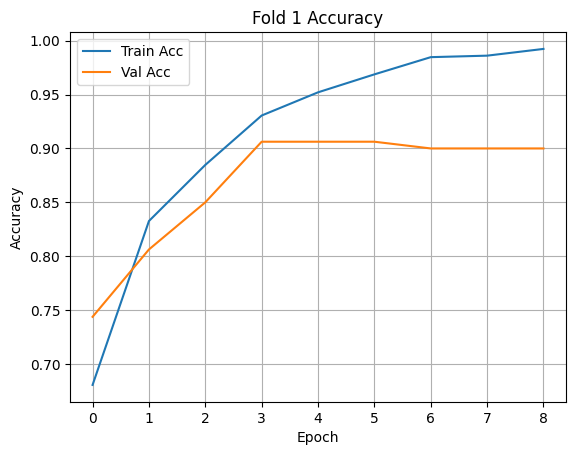

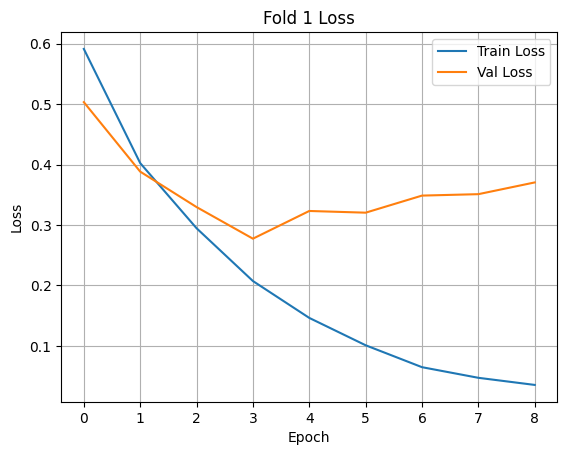

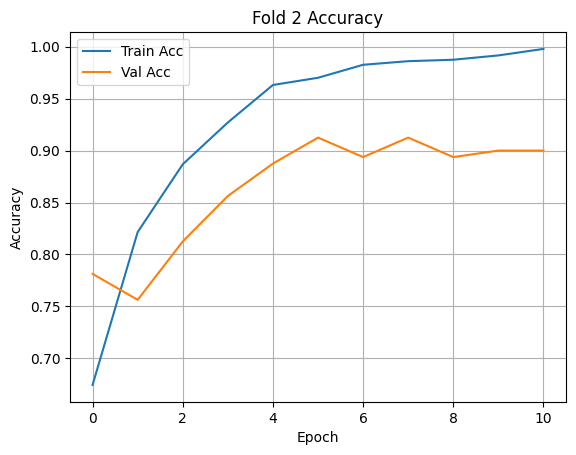

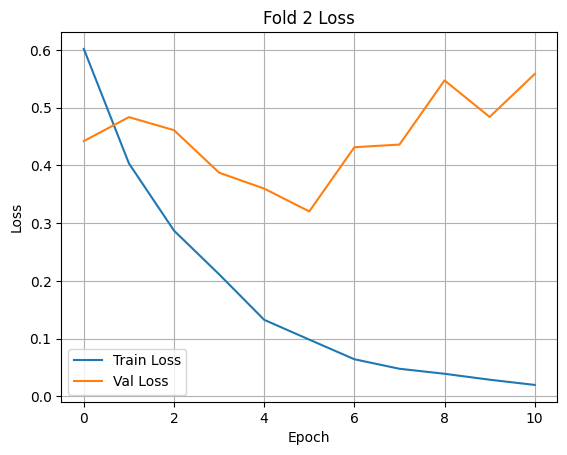

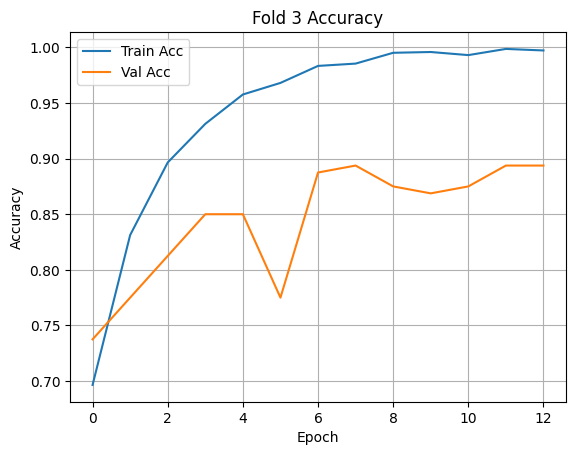

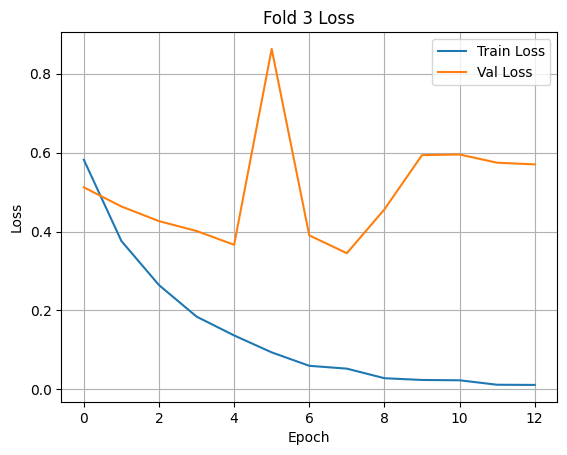

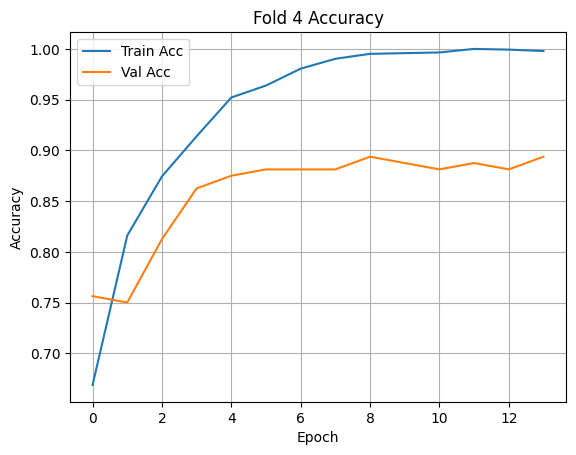

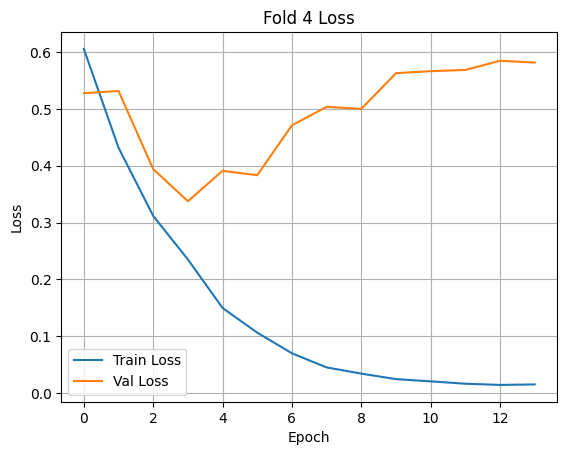

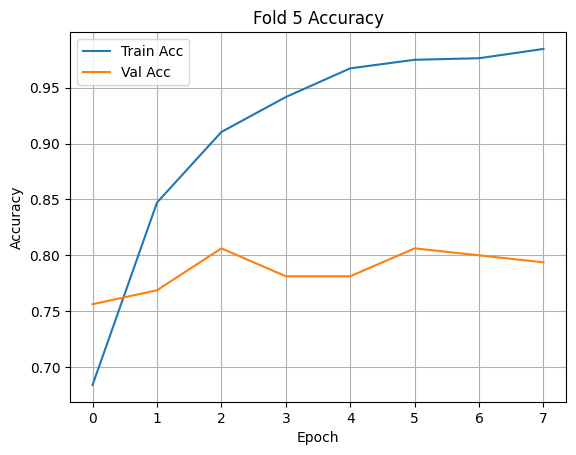

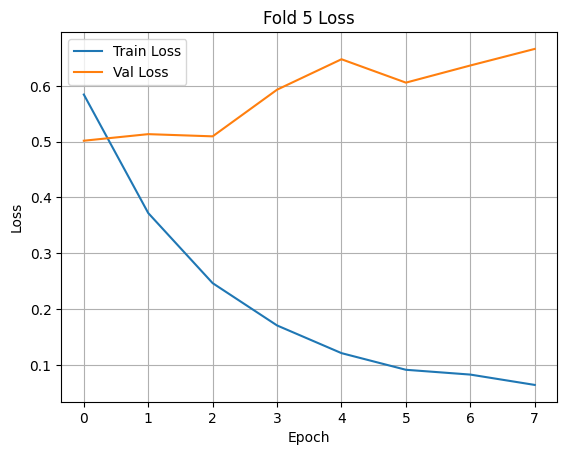

In [11]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# Save mô hình fold cuối cùng
model.save("BiGRU_Multi_Head_Attention_HMM_final.h5")

In [13]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.849000
precision    0.839051
recall       0.879000
f1           0.853759
auc          0.936882
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8325,0.767068,0.955,0.850780,0.937625
1,2,0.8425,0.807175,0.900,0.851064,0.926050
2,3,0.8325,0.780591,0.925,0.846682,0.927287
3,4,0.8750,0.921348,0.820,0.867725,0.953650
4,5,0.8625,0.919075,0.795,0.852547,0.939800


In [14]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.849000
precision    0.839051
recall       0.879000
f1           0.853759
auc          0.936882
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8490
📈 Range Accuracy: 0.0425
📉 Accuracy CV% (std/mean): 2.24%


,fold,accuracy,precision,recall,f1,auc
0,1,0.8325,0.767068,0.955,0.850780,0.937625
1,2,0.8425,0.807175,0.900,0.851064,0.926050
2,3,0.8325,0.780591,0.925,0.846682,0.927287
3,4,0.8750,0.921348,0.820,0.867725,0.953650
4,5,0.8625,0.919075,0.795,0.852547,0.939800
